<h1><u>Yelp Review Aggregator</u></h1>

Team: Better Late than never

<h3>Intro</h3>

The motivation for this project came from a late-night conversation about the kind of people who write Yelp reviews. We imagined most of them as either entralled, Karen-level angry, or gaming the system to get new business. This led to us thinking about the feasability of getting solid restaurant recommendations from Yelp data. How cool would it be to have an app to recommend delicious food nearby, within your price range? I would absolutely use this information to try to impress someone on a first date. But first, we had to take a closer look at the data



<h3><u>Data</u></h3>

Our project used the Yelp Open dataset, a public dataset for educational use. It spans over 150K businesses, over 7 million reviews, and almost 2 million users. The dataset covers 11 metropolitan areas over 20+ states in the United States. Reviews were collected between Feb 16, 2005 and Jan 19, 2022.

To clean the data, we first removed all non-restaurants from the dataset. Next, we removed all restaurants with less than 30 reviews. We then removed all reviews not pertaining to the restaurants left in the dataset. Lastly, we removed all users who did not write a review about the remaining restaurants. The following code cell outputs the results of cleaning (the dataset is too large to submit)

Source: https://business.yelp.com/data/resources/open-dataset/

In [1]:
import data_cleaning as clean
import SonyaHelperFunctions
chunk_size = 100_000

# We assume that the raw yelp dataset has been extracted to the folder 'data'
restaurants_df = clean.filter_business_data("data/yelp_academic_dataset_business.json", chunk_size)
reviews_df = clean.filter_review_data("data/yelp_academic_dataset_review.json", restaurants_df, chunk_size)
users_df = clean.filter_user_data("data/yelp_academic_dataset_user.json", reviews_df, chunk_size)

print(f'Number of restaurants after cleaning: {restaurants_df.shape[0]}')
print(f'Number of reviews after cleaning: {reviews_df.shape[0]}')
print(f'Number of users after cleaning: {users_df.shape[0]}')

Number of restaurants after cleaning: 27894
Number of reviews after cleaning: 4371282
Number of users after cleaning: 1379980


Text - EDA - Distribution of Reviews and Review Scores

TODO: Describe viz and takeaways

In [ ]:
## Run code for viz 1 - distribution of review scores

## Run

Text - EDA #1 - Heatmap of average score prices

TODO: Describe viz and takeaways

In [ ]:
## output viz

# TODO: Harket - create .py file to output viz

Text - EDA #2 - Average score vs price

Below is a box graph of the average review score of restaurants grouped by the price range as reported by Yelp. As can be seen, the mean review score increases as the price of the restaurant increases. However, not every restaurant has a price range reported, and the range is inherently imprecise (given that it runs from 1 to 4, represented by consecutive dollar signs, so a 3 is $$$), so some bias is inherent. Further, there are a massive number of outliers, showing that the correllation isn't strong. Further, there are peaks of 5 or nearly 5 star rated restaurants in the lower price ranges, where such high scores are unseen in price ranges 3 and 4. This suggests even further outliers. As well, most of this data was reported pre-pandemic, and we're going on price range as a single number, when it is entirely possible that a restaurant's price range would fluctuate over time.

All these caveats taken into consideration, the correlation still makes some intuitive sense. More expensive restaurants would draw in more seasoned reviewers, and people who dine at expensive places and enjoyed their time seem more likely to rate a restaurant highly. Further, more expensive meals would lead to the restaurants having more income, which can be spent on better ingredients.



C:\Users\Alzier\Desktop\DataScience\YelpProject\Yelp JSON\group-project-better-late-than-never\SonyaHelperFunctions.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  axes=sns.boxplot(data=restaurants_df, x="PriceRange", y="avg_review_score", palette="mako", order=[1,2,3,4])


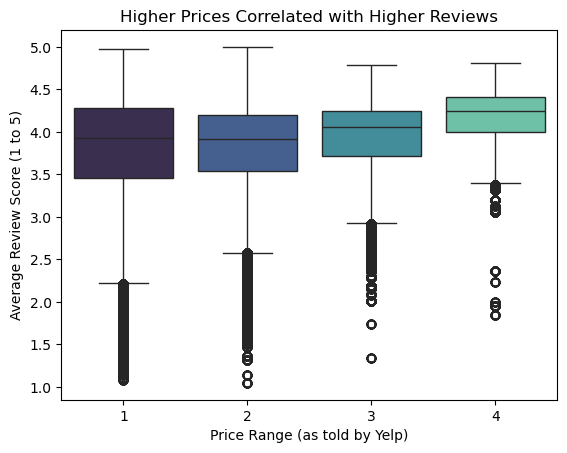

In [2]:
## Output viz
newRestaurantsWithAverageStars=SonyaHelperFunctions.make_restaurants_with_avg_stars(reviews_df, restaurants_df)
priceRangeDF=SonyaHelperFunctions.add_price_range_to_df(newRestaurantsWithAverageStars)
SonyaHelperFunctions.show_price_plot(priceRangeDF)

<h3><u>ML #1 - Binary Classification of Review Text</u></h3>

After looking at review scores, we turned to review text. We wanted to see if the text of a review aligned with the review's score, bias and all. To do this, we created a machine learning model to classify review text as 'Bad' (score < 4) or 'Good' (score >= 4). We trained a SVC with 50K reviews using the cuml library, a GPU-accelerated version of sklearn. Our features were a matrix of TF-IDF vectors. To benchmark, we compared the accuracy of our model to a majority label classifier using 5K reviews unused in training. We cross-validated to find the most effective SVC kernel and number of data points, but didn't find a significant difference in model accuracy from our tuning

Our model beat our benchmark by almost 20%, not bad. It suggested an association between the score of a review and the text of the review. To further investigate, we created a second model with three classes

In [ ]:
import text_analysis as ml
benchmark_size = 5000

train_X, train_, binary_tfidf, binary_classifier = ml.load_model("binary")
test_X, test_y = ml.create_binary_test_data(reviews_df, benchmark_size, binary_tfidf)

ml.benchmark(test_X, test_y)
ml.evaluate_classifier(binary_classifier, test_X, test_y)

cuML: Installed accelerator for sklearn.
cuML: Successfully initialized accelerator.
Benchmark accuracy for our model to beat: 0.6928066037735849
Model Accuracy: 0.8876768867924528


<h3><u>ML #2 - Three-way Classification of Review Text</u></h3>

This model was a SVC like the first, except it classifies the text of a review (In TF-IDF vector form) as 'Bad' (review score < 4), 'Good' (4 <= review score < 5), or 'Great' (review score == 5). cuML was unable to use GPU-acceleration on this kind of model, so we used sklearn instead. The SVC was trained using the 'One vs. Rest' strategy. This meant that the SVC consisted of 3 SVMs, one for each label. We used 50K reviews in training, and 5K seperate reviews for benchmarking. We used the same majority label classifier to benchmark this model

This benchmark beat the benchmark by almost 30%, more than the binary model. This further suggested an association between a review's score and text. It also suggests that any bias in the review score is also present in the review text. Both are user input

In [3]:
train_X, train_, three_tfidf, three_classifier = ml.load_model("3_class")
test_X, test_y = ml.create_multiclass_test_data(reviews_df, benchmark_size, three_tfidf)

ml.benchmark(test_X, test_y)
ml.evaluate_classifier(three_classifier, test_X, test_y)

Benchmark accuracy for our model to beat: 0.4206957547169811
Model Accuracy: 0.7054834905660378


<h3>Results</h3>

Our research boils down to two major takeaways:
<h5>1. Yelp data is biased</h5>


<h5>2. Yelp bias is user input, at least in part</h5>

<h3><u>App Demo</u></h3>

https://yelp-recs.crowsnet.io

In spite of the bias in Yelp data, we decided that solid restaurant recommendations could still be pulled out of the data. So we built an app to give recommendations for food in Chicago!

We started by pulling the highest-rated restaurants from each of 178 Chicago neighborhoods using the Yelp API. We were rate-limited, so we were only able to pull the top 240 restaurants from each neighborhood. The process took us one week in total

To clean our pulled data, we first created a column 'neighborhood' and recorded the neighborhood of each restaurant as we pulled it in. This would become useful for sorting. We also cleaned the 'categories' column of the data to yield only 1 of 11 categories for each restaurant (We had a catch-all 'Other' that a significant number of restaurants fell into here). Last, we transformed the price ranges from $-$$$$ to 1-4. This resulted in 3 searchable components: Neighborhood, Category and Price Range

To use these components to get recommendations, we created a Flask app. The front-end is a simple HTML page with a form for the user to select Neighborhood, Category, and Price Range. The back-end takes this form data, runs a pandas query, and returns the 5 highest-rated restaurants with these parameters. The app was deployed in a Docker container on a virtual machine, and securely self-hosted using NGINX Proxy Manager on a seperate virtual machine